# General information
 * Author: Joris Busink, Junior Teacher Physics Education.
 * Date: Tue, 25th Okt.
 * About: Data-analysis and data-visualization using Python 3.

 For questions please email: J.Busink@vu.nl.

# Example: Analysis of a pendulum (SHO)

<a href='#LoadPackages'> 1. Load packages.</a><br>
<a href='#model'> 2. Model and mock data.</a><br>
<a href='#plot'> 3. Plot data.</a><br>
<a href='#fit'> 4. Fit data to model.</a><br>
<a href='#residuals'> 5. Plot residuals.</a><br>
<a href='#chisq'> 6. Calculate (reduced) $\chi^2$.</a><br>


## Load packages <a id='LoadPackages'></a>
I load the following packages: numpy, matplotlib.pyplot,lmfit and pandas. These pacakges are always useful in doing nummerical calculations using Python.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lmfit
import matplotlib.gridspec as gridspec

np.set_printoptions(precision=4,threshold =9,suppress=True)  #Compact display.

## Model and mock data<a id='model'></a>
<!-- ![Simple Pendulum](Pendulum_theory_100dpi.png)<br> -->

![Simple Pendulum](https://raw.githubusercontent.com/JBusink/Curve-Fit/main/Figures/Pendulum_theory_100dpi.png?token=GHSAT0AAAAAABZBXVFTG7EJEG242G7LAYOMY22RN2Q)

Here I create a mock-data set of a damped harmonic oscillator. <br>

The x-data is an array (a <em>list</em> that allows nummerical manipulations) that represents the time-domain of the oscillator that ranges from 0 to 10, with $\delta t$ = 0.2. <br>
The y-data is, for example the x-position of the oscillator, created by evaluating the Simple Harmonic Oscillator model function: <br>

\begin{equation}
    y(t) = 2e^{-0.2t}\sin(3t)+0.05t\zeta(t).
    \tag{1}
\end{equation}

The harmonic response is given by $\sin(\omega t)$ with $\omega$ = 3 $t^{-1}$, the damping term is included by an exponential decay $e^{\gamma t}$, with $\gamma = 0.2$ $t^{-1}$ the damping term.<br>
The last term, $0.05t\zeta(t)$ account for a stochastic proccess. $\zeta(t)$ is a uniform number (float) from -1 to 1. The exact details of the process are not import.

* Line 1: create random seed (to replicate noise).

* Line 3-4: generate x-data and y-data.

* Line 5-6: noise in x-data and y-data.

Note that I define my dataset as x-and y-coordinates, but for a physical pendulum this can be interpreted as time-data and x-position data!<br>


In [13]:
np.random.seed(2) #initialize random number generator seed.

x = np.arange(0,10.2,0.2) # x-axis data, an array ('list') from [0,0.2...9.8, 10].
y = 2*np.exp(-0.2*x)*np.sin(3*x) + 0.05*x*np.random.uniform(-1,1,len(x)) # y-axis data.
xerr = 0.1 # constant error in time.
yerr = 0.1*y +0.2 # The error in x-position.

## plot the data<a id='plot'></a>
In the next lines of code I will plot the data. 
Our data is 2 dimensional (x,y) and contains errors, so we use an errorbar plot. 

* Line 1: create 1 figure (1 row and 1 column). [Figure documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

* Line 2: plot data using an errorbarplot. [Errorbar documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html)

* Line 3-8: optional commands.

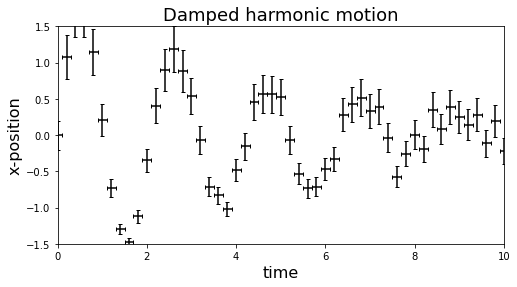

In [14]:
fig, axes = plt.subplots(1,1,figsize=(8,4)) #Creates a single figure with dimensions (12 by 6 (inch))
axes.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='none',ecolor='black',capsize=2) #fmt, ecolor and capsize can be personalized.
axes.set_title('Damped harmonic motion', fontsize=18)
axes.set_xlabel('time',fontsize=16)
axes.set_ylabel('x-position',fontsize=16)
axes.set_xlim(np.min(x),np.max(x))
axes.set_ylim(-1.5,1.5)
plt.show()

## Fit data to model<a id='fit'></a>

* Line 1-2: Here we define our model (sinus_model()) using a Python function: a function starts with <em>def</em> and ends with <em>return</em>.<br>
Sinus_model() is our user defined model based on the theory. We vary the time coordinate (the independent variable, t) and the parameters ($x_0$, A, $\omega$ and $\phi$) are determined by a fit.<br> 
Be careful that the independent variable (t) must appear<em> before </em> the parameters, otherwise an error message will appear.<br>

* Line 4: Apply a fit using the curve_fit function. [Curve_fit documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)<br>

Curve_fit asks for a minimum of three input arguments: (model, independent variable (time), dependent variable (x-coordinate)), more input arguments are optional.<br> 
In our case, I provide an initial guess of the optimal parameters ($p_0$). Other options include: bounds, weights, method, etc. <br>
Note that providing a good initial guess of $p_0$ and apply parameter bounds significantly reduces the complexity of finding the optimal parameters, if possible, provided them!<br>
<br>
The output of curve_fit are the optimal parameters <em>popt</em> and the covariance matrix $\mathcal{K_{p_i p_j}}$ <em>pcov</em>, where $\mathcal{K_{p_i p_j}}$ is defined as: <br>

\begin{equation}
    \mathcal{K_{p_i p_j}}= \begin{bmatrix} s_{p_a p_a} & s_{p_b p_a} \\ s_{p_a p_b} & s_{p_b p_b} \end{bmatrix}
    \tag{2}
\end{equation}

For example, $s_{p_a p_a}$ is the (co)variance of parameter a. To obtain the standard deviation $\sigma_{a}$ of parameter a we take the square root of the variance:

\begin{equation}
    \sigma_{a} = \sqrt{s_{p_a p_a}}
    \tag{3}
\end{equation} 

* Line 6-8: Show the optimal values and corresponding standard deviations. <br>

* Line 10-15: Make figure, plot the data (black) and the fit (darkred).<br>

We plot the fit by making a new dataset, called xfit. We evaluate the the function using the optimal parameters at the values of xfit.

* Line 17-25: Optional commands. <br>

* Line 27-28: Save the figure.<br> 

Note that the figure is saved as a .svg extension. A .svg extension stands for Scalable Vector Image, the image is saved as an object (and not as a collection of pixels). <br>
One can import .svg picture in e.g. inkscape, powerpoint or adobe photoshop to manipulate these, try it!.<br>

The optimal value for  Amplitude (m) is: 2.0334 ± 0.069732
The optimal value for  Gamma (1/s) is: 0.2001 ± 0.013630
The optimal value for  Frequency (rad/s) is: 3.0024 ± 0.014051
The optimal value for  phase (rad) is: -0.0196 ± 0.040323


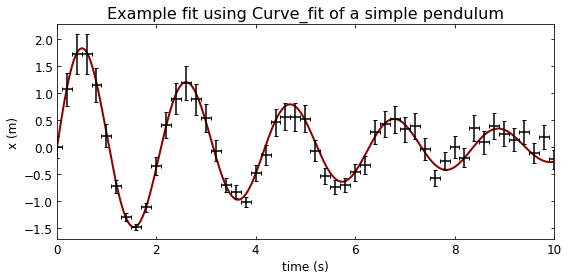

In [15]:
def sinus_model(t,A,gamma,omega,phi):
    return A*np.exp(-gamma*t)*np.sin(omega*t+phi)

popt, pcov = curve_fit(sinus_model,x,y,sigma = yerr,p0=[1,0.1,4.12,0.5])

parameter=['Amplitude (m)','Gamma (1/s)', 'Frequency (rad/s)', 'phase (rad)']
for i in range (4):
    print("The optimal value for ", parameter[i], 'is:', "{:.4f}".format(popt[i]), '\u00B1', "{:.6f}".format(np.sqrt(pcov[i,i])))

xfit = np.linspace(0,max(x),10000) #create new data for fit.

#Plot data + fit        
fig,axes=plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
axes.plot(xfit,sinus_model(xfit,*popt), color ='darkred', lw = 2,zorder =1) #plot fit
axes.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='none',ecolor='black',capsize=2) #fmt, ecolor and capsize can be personalized.

#plot axis labels and limits
axes.set_title('Example fit using Curve_fit of a simple pendulum',fontsize=16)
axes.set_xlabel('time (s)',fontsize=12)
axes.set_ylabel('x (m)',fontsize=12)
axes.set_xlim(0,10)

#Some plot settings
axes.tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
plt.tight_layout() #creates optimal padding levels for figure (especially usefull for side-by-side figures)

# location='Path' #Path to your prefered location, e.g. User/Downloads/
# plt.savefig(location+'simple_pendulum.svg') #Extension can be .png/.jpg/.etc or .svg/.pdf (Vector Image)

plt.show()

## Optional: Residuals <a id='residuals'></a>
In the previous section we fit a model to our data. We observe that the sinusoidal fit captures the data very well.<br>
However, we are also interested in the limitations of the fit. To spot these limitations can be cumbersome, to simplify our life, we calculate the difference<br>
between the data and the fit: the residuals. To visualize the residuals I will make a grid using gridspec. Using gridspec we can make two subfigures, a main figure and a sub (residuals) figure.<br>
In the main figure I plot the data and optimal fit. In the residuals plot I plot the difference of the data and the fit, <br>the residuals $r$ of the data:

\begin{equation}
    r = y_{data}-y_{model}.
    \tag{4}
\end{equation}

The residual plot shows valuable information. For example, a systematic pattern in the residuals shows that our model cannot capture the full data.<br>
In principle, we should modify our, thereby correcting for the systematic error. 

For a more extensive discussion about the meaning of a residual I refer to chapter 4.2 in An Introduction to Error Analysis, by John R. Taylor.

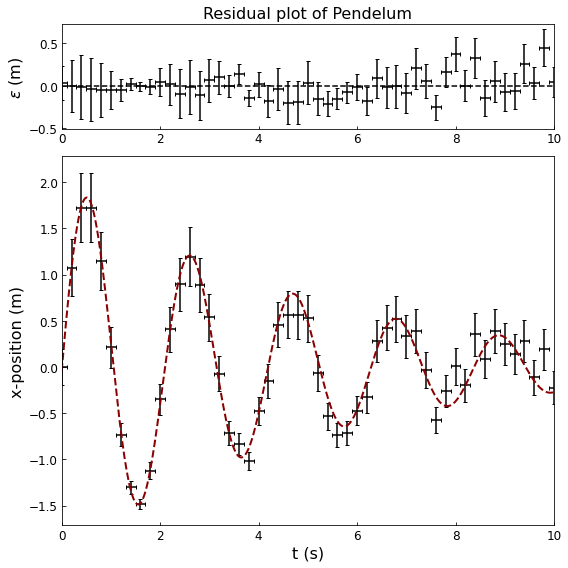

In [16]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:4, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.tick_params(axis='both',direction ='in',labelsize=12)
axes_main.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='none',ecolor='black',capsize=2) #fmt, ecolor and capsize can be personalized.
axes_main.plot(xfit,sinus_model(xfit,*popt),color='darkred',ls='--', lw=2)
axes_main.set_xlabel('t (s)',fontsize=16)
axes_main.set_ylabel('x-position (m)',fontsize=16)
axes_main.set_xlim(0,10)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Residual plot of Pendelum',fontsize=16)
axes_residuals.errorbar(x,y-sinus_model(x,*popt),xerr=xerr,yerr=yerr,fmt='none',ecolor='black',capsize=2) #fmt, ecolor and capsize can be personalized.

axes_residuals.hlines(0,np.min(x),np.max(x),color='black',ls='--')
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
axes_residuals.set_xlim(0,10)

plt.tight_layout()
plt.show()


## reduced $\chi^2$ <a id='chisq'></a>
In the previous figure we observed that our fit captures the data nicely. In the residuals we observe that after t $\approx$ 7,<br>
the noise starts to dominate.
In principle we could quanitfy the deviation between the observed and expected data using the $\chi^2$ analysis: <br>

\begin{equation}
    \chi^2 = \sum_{1}^{N}\frac{(y_i-f(x_i))^2}{\sigma_i^2}=\sum_{1}^{N}\frac{r_i^2}{\sigma_i^2}. 
    \tag{5}
\end{equation}

$\sigma_{i}$ is the standard deviation 'error' on the observed datapoint $y_i$. 
Lastly, we should correct for the number of <em>degrees of freedom</em>. We have N data points and c parameters, so we have<br>
d = N - c <em>degrees of freedom</em>. We define the following:

\begin{equation}
    \tilde{\chi}^2 =\frac{\chi^2}{d},
    \tag{6}
\end{equation}

$\tilde{\chi}^2$ is the reduced $\chi^2$, where we included the effect of the degrees of freedom. The value of $\tilde{\chi}^2$ is a measure of the deviation<br> 
between the data and the model.<br>

For a more general discussion about the significance and applicability of $\tilde{\chi}^2$ I refer to chapter 12 in An Introduction to Error Analysis by John R. Taylor.

In [17]:
chisq = np.sum(((y-sinus_model(x,*popt))/yerr)**2)
d = len(y) - len(popt)
red_chisq = chisq/d
print("chi-squared = %.4f" % chisq)
print("df = %d" % d)
print("Reduced chi-squared = %.4f" % red_chisq)

chi-squared = 29.2034
df = 47
Reduced chi-squared = 0.6213


## Confidence Intervals

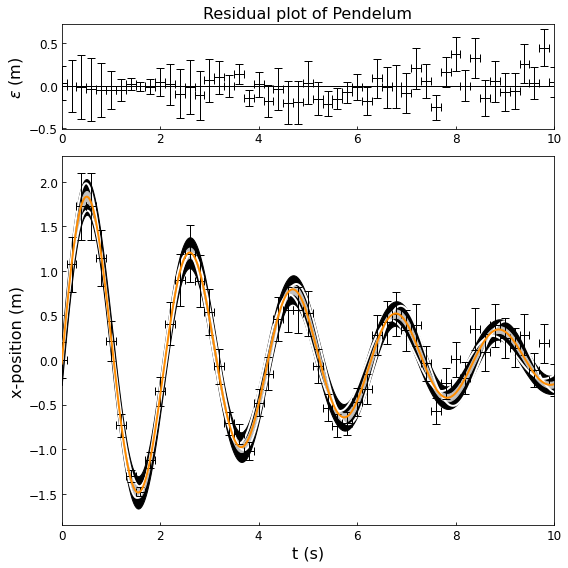

In [18]:
import matplotlib.gridspec as gridspec
import scipy.stats as st


popt0 = popt[0]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[0]
popt1 = popt[1]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[1]
popt2 = popt[2]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[2]
popt3 = popt[3]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[3]
ylist =[]
for i in range(0,125,1):
    ydat = sinus_model(xfit,popt0[i],popt1[i],popt2[i],popt3[i])
    ylist.append(ydat)
    
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:4, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.tick_params(axis='both',direction ='in',labelsize=12)
axes_main.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='none',ecolor='black',capsize=4,elinewidth=1, marker = 's',zorder=5) #fmt, ecolor and capsize can be personalized.
axes_main.plot(xfit,sinus_model(xfit,*popt),color='darkorange',ls='-', lw=2,zorder =5)
axes_main.plot(xfit,sinus_model(xfit,popt[0]-3*np.sqrt(np.diag(pcov))[0],popt[1]-3*np.sqrt(np.diag(pcov))[1],popt[2]-3*np.sqrt(np.diag(pcov))[2],popt[3]),color='white',ls='-', lw=2,zorder=4)
axes_main.plot(xfit,sinus_model(xfit,popt[0]+3*np.sqrt(np.diag(pcov))[0],popt[1]+3*np.sqrt(np.diag(pcov))[1],popt[2]+3*np.sqrt(np.diag(pcov))[2],popt[3]),color='white',ls='-', lw=2,zorder=4)


axes_main.fill_between(xfit,np.mean(ylist,axis=0)+3*np.std(ylist,axis=0),np.mean(ylist,axis=0)-3*np.std(ylist,axis=0),color='black')
axes_main.fill_between(xfit,np.mean(ylist,axis=0)+1*np.std(ylist,axis=0),np.mean(ylist,axis=0)-1*np.std(ylist,axis=0),color='silver')
axes_main.set_xlabel('t (s)',fontsize=16)
axes_main.set_ylabel('x-position (m)',fontsize=16)
axes_main.set_xlim(0,10)

axes_residuals.errorbar(x,y-sinus_model(x,*popt),xerr=xerr,yerr=yerr,fmt='none',ecolor='black',capsize=4,elinewidth=1) #fmt, ecolor and capsize can be personalized.
axes_residuals.hlines(0,np.min(x),np.max(x),color='black',ls='-',lw=1)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Residual plot of Pendelum',fontsize=16)
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
axes_residuals.set_xlim(0,10)

plt.tight_layout()
plt.show()


# Example: fit data using LmFit

In [19]:
from lmfit import models

#Define model:
model = models.Model(lambda t, Amplitude, Gamma, Omega,Phi: Amplitude * np.exp(-Gamma * t) * np.sin(Omega*t+Phi))

#Initialize parameters (p0)
params = model.make_params(Amplitude=2, Gamma=0.2, Omega=3,Phi=2)

#Provide bounds
params['Amplitude'].min = 0

#Fit data using model.fit
fit = model.fit(y, t=x, params=params,weights = 1/yerr)

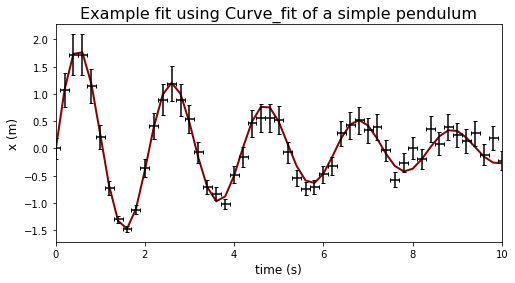

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 51
    # variables        = 4
    chi-square         = 29.2033938
    reduced chi-square = 0.62134880
    Akaike info crit   = -20.4345760
    Bayesian info crit = -12.7072734
[[Variables]]
    Amplitude:  2.03342725 +/- 0.06972568 (3.43%) (init = 2)
    Gamma:      0.20010262 +/- 0.01362861 (6.81%) (init = 0.2)
    Omega:      3.00239469 +/- 0.01404992 (0.47%) (init = 3)
    Phi:       -0.01955395 +/- 0.04032279 (206.21%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(Amplitude, Gamma) = 0.838
    C(Omega, Phi)       = -0.761
    C(Amplitude, Phi)   = -0.137
    C(Gamma, Phi)       = -0.109


In [20]:
fig,axes=plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
axes.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='none',ecolor='black',capsize=2) #fmt, ecolor and capsize can be personalized.
axes.plot(x, fit.best_fit, color='darkred',lw=2,zorder =1)#plot fit

#plot axis labels and limits
axes.set_title('Example fit using Curve_fit of a simple pendulum',fontsize=16)
axes.set_xlabel('time (s)',fontsize=12)
axes.set_ylabel('x (m)',fontsize=12)
axes.set_xlim(0,10)
plt.show()

#print fit report
print(fit.fit_report())

# Your Experiment starts here

* Author: Student name
* Date: date
* About: Your experiment<br>
* TA:

Please ask your TA if you need to hand in your code at the end of the practical course.

In [21]:
# %reset -f #Clears cache memory, can also be manually done above.